## Translation Noises

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# The noises from --> Training Dataset's predictions in Step1's Model

import numpy as np
import src.models.common.MyDataset as MyDataset

Y_pred_dir = "/data/gpfs/projects/punim1836/CT-MRI_LandmarkDetection/models_MR/divided_MR/176x88x48/variable_voxel_distance/mean_two_landmarks/straight_model/learning_rate/0.0001/13Sep2024-10:42:13-trainID-2"

Y_gt_file = "Y_test_true.npy"
Y_pre_file = "best_val_Y_test_pred.npy"

Y_gt = np.load(f"{Y_pred_dir}/{Y_gt_file}")
Y_pre = np.load(f"{Y_pred_dir}/{Y_pre_file}")

In [3]:
# MR resolution

res_file_path = "/data/gpfs/projects/punim1836/CT-MRI_LandmarkDetection/models_MR/divided_MR/176x88x48/variable_voxel_distance/mean_two_landmarks/straight_model/learning_rate/0.0001/13Sep2024-10:42:13-trainID-2/res_test.npy"
res = np.load(res_file_path)

In [4]:
# distance in Voxel
Y_err_dis = Y_gt - Y_pre
sum_square_err_diff = np.sum(np.power(Y_err_dis, 2), axis= (1,2))
err_dis = np.sqrt(sum_square_err_diff)

min_err_idx = np.argmin(err_dis, axis=0)
max_err_idx = np.argmax(err_dis, axis=0)
print(f"Min[{min_err_idx}]: {err_dis[min_err_idx]}")
print(f"Max[{max_err_idx}]: {err_dis[max_err_idx]}")
print(f"Mean: {np.mean(err_dis)}")

Min[32]: 0.06671085953712463
Max[118]: 2.350708246231079
Mean: 0.8235194683074951


In [5]:
# distance in MM
Y_err_dis = (Y_gt - Y_pre) * res
sum_square_err_diff = np.sum(np.power(Y_err_dis, 2), axis= (1,2))
err_dis = np.sqrt(sum_square_err_diff)

min_err_idx = np.argmin(err_dis, axis=0)
max_err_idx = np.argmax(err_dis, axis=0)
print(f"Min[{min_err_idx}]: {err_dis[min_err_idx]}")
print(f"Max[{max_err_idx}]: {err_dis[max_err_idx]}")
print(f"Mean: {np.mean(err_dis)}")

Min[32]: 0.08258695900440216
Max[156]: 3.4544596672058105
Mean: 0.9229074716567993


## find a distribution for noises

In [6]:
## Test dataset noises Distribution
## Skew Normal Distribution

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

a, loc, scale = 1.3, -0.1, 2.2
sample = stats.skewnorm(a, loc, scale).rvs(1000)

In [7]:
a_x, loc_x, scale_x = stats.skewnorm.fit(Y_err_dis[:, 0, 0])

a_y, loc_y, scale_y = stats.skewnorm.fit(Y_err_dis[:, 0, 1])

a_z, loc_z, scale_z = stats.skewnorm.fit(Y_err_dis[:, 0, 2])

In [8]:
print("a_x: ", a_x)
print("loc_x: ", loc_x)
print("scale-x: ", scale_x)

print("a_y: ", a_y)
print("loc_y: ", loc_y)
print("scale-y: ", scale_y)

print("a_z: ", a_z)
print("loc_z: ", loc_z)
print("scale-z: ", scale_z)

a_x:  2.779407324663132
loc_x:  -0.7855089385055054
scale-x:  0.693392546940967
a_y:  -3.328285908044798
loc_y:  0.26377208018030707
scale-y:  0.716596938494875
a_z:  -1.6418829339781293
loc_z:  0.17727861570484815
scale-z:  0.8390552770788883


In [9]:
sn_x = stats.skewnorm(a_x, loc_x, scale_x)
x = np.linspace(sn_x.ppf(0.01), sn_x.ppf(0.99), 400)

sn_y = stats.skewnorm(a_y, loc_y, scale_y)
y = np.linspace(sn_y.ppf(0.01), sn_y.ppf(0.99), 400)

sn_z = stats.skewnorm(a_z, loc_z, scale_z)
z = np.linspace(sn_z.ppf(0.01), sn_z.ppf(0.99), 400)

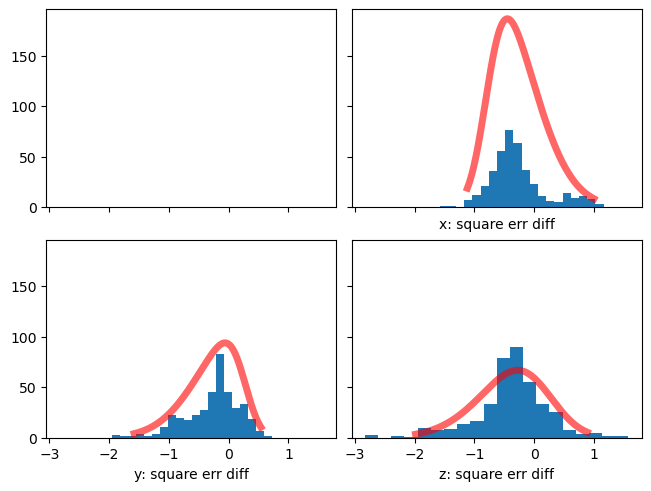

In [10]:
from matplotlib import pyplot

fig, axs = pyplot.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True)

# axs[0][0].hist(sum_square_err_diff, 20)
# axs[0][0].set_xlabel("sum square err diff")

axs[0][1].hist(Y_err_dis[:, 0, 0], 20)
axs[0][1].set_xlabel("x: square err diff")
axs[0][1].plot(x, sn_x.pdf(x)*200, 'r-', lw=5, alpha=0.6)

axs[1][0].hist(Y_err_dis[:, 0, 1], 20)
axs[1][0].set_xlabel("y: square err diff")
axs[1][0].plot(y, sn_y.pdf(y)*100, 'r-', lw=5, alpha=0.6)

axs[1][1].hist(Y_err_dis[:, 0, 2], 20)
axs[1][1].set_xlabel("z: square err diff")
axs[1][1].plot(z, sn_z.pdf(z)*100, 'r-', lw=5, alpha=0.6)

pyplot.show()


In [11]:
s1_pred_test_dis_array = np.zeros((2000, 1, 3))
s1_pred_test_dis_array[:, 0, 0] = sn_x.rvs(size=2000)
s1_pred_test_dis_array[:, 0, 1] = sn_y.rvs(size=2000)
s1_pred_test_dis_array[:, 0, 2] = sn_z.rvs(size=2000)

In [26]:
# convert to distance in mm
# s1_pred_test_dis_array = s1_pred_test_dis_array * 0.15

In [12]:
check_r_p2 = np.sum(np.power(s1_pred_test_dis_array, 2), axis= (1,2))
check_r = np.sqrt(check_r_p2)

print(np.mean(check_r, axis=0))

0.9591546598808613


In [13]:
file_name = "noises_s1.5_test_dis"
np.save(f"{Y_pred_dir}/{file_name}", s1_pred_test_dis_array)